<a href="https://colab.research.google.com/github/julidoominguez/SeriesdeTiempoAustral/blob/main/TP2_Modelo__de_ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importamos librerias

In [ ]:
import pandas as pd
import lightgbm as lgb
!pip install sktime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
import joblib


### Cargamos los datos

In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1OVJRz3bjcKnrTl62DdEbvJTrMlDYCLFmRILtqNJgTvs/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_vitalcer = pd.read_csv(csv_url)

### Preparamos los datos

In [ ]:
# Convertir todas las columnas excepto 'Fecha' a tipo numérico
for col in df_vitalcer.columns:
    if col != 'fecha':  # Excluir la columna 'Fecha'
        if df_vitalcer[col].dtype == 'object':
            df_vitalcer[col] = df_vitalcer[col].str.replace(',', '.')
        df_vitalcer[col] = pd.to_numeric(df_vitalcer[col], errors='coerce')


In [ ]:
# Imputar valores nulos en las columnas 'Visitas pagina' y 'Alcance IG' con 0
df_vitalcer['Visitas pagina'].fillna(0, inplace=True)
df_vitalcer['Alcance IG'].fillna(0, inplace=True)

In [ ]:
df_vitalcer['fecha'] = pd.to_datetime(df_vitalcer['fecha'])

In [ ]:
# Feature Enginering
df_vitalcer["day_of_week"] = df_vitalcer["fecha"].dt.dayofweek
df_vitalcer["day_of_year"] = df_vitalcer["fecha"].dt.dayofyear
df_vitalcer["month"] = df_vitalcer["fecha"].dt.month
df_vitalcer["quarter"] = df_vitalcer["fecha"].dt.quarter
df_vitalcer["year"] = df_vitalcer["fecha"].dt.year

df_vitalcer.head()

,fecha,Monto_deflactado,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,indumentaria_calzado_textiles_hogar,electronicos_articulos_hogar,otros,Visitas pagina,Alcance IG,day_of_week,day_of_year,month,quarter,year
0,2019-11-15,595695.0318,62,66.94,3867.0,49574.33,239.44,243.4,246.54,238.13,...,2197595.469,4638017.913,7726583.681,0.0,0.0,4,319,11,4,2019
1,2019-11-16,460448.3130,60,75.19,3867.0,49574.33,239.44,243.4,246.54,238.13,...,2197595.469,4638017.913,7726583.681,0.0,0.0,5,320,11,4,2019
2,2019-11-17,0.0000,0,0.00,3867.0,49574.33,239.44,243.4,246.54,238.13,...,2197595.469,4638017.913,7726583.681,0.0,0.0,6,321,11,4,2019
3,2019-11-18,0.0000,0,0.00,3867.0,49574.33,239.44,243.4,246.54,238.13,...,2197595.469,4638017.913,7726583.681,0.0,0.0,0,322,11,4,2019
4,2019-11-19,606252.4772,88,73.75,3867.0,49574.33,239.44,243.4,246.54,238.13,...,2197595.469,4638017.913,7726583.681,0.0,0.0,1,323,11,4,2019


In [ ]:
import pandas as pd
import numpy as np
import holidays

# Características de Tiempo Adicionales
df_vitalcer["day_of_week"] = df_vitalcer["fecha"].dt.dayofweek
df_vitalcer["day_of_month"] = df_vitalcer["fecha"].dt.day
df_vitalcer["week_of_year"] = df_vitalcer["fecha"].dt.isocalendar().week
df_vitalcer["month"] = df_vitalcer["fecha"].dt.month
df_vitalcer["quarter"] = df_vitalcer["fecha"].dt.quarter
df_vitalcer["year"] = df_vitalcer["fecha"].dt.year
df_vitalcer["is_weekend"] = (df_vitalcer["fecha"].dt.dayofweek >= 5).astype(int)

# Características Derivadas de Fechas
df_vitalcer["days_since_start"] = (df_vitalcer["fecha"] - df_vitalcer["fecha"].min()).dt.days
df_vitalcer["days_to_end_of_year"] = (df_vitalcer["fecha"] + pd.offsets.YearEnd() - df_vitalcer["fecha"]).dt.days

# Días festivos de Argentina
argentine_holidays = holidays.AR(years=df_vitalcer["fecha"].dt.year.unique(), observed=True)
df_vitalcer["is_holiday"] = df_vitalcer["fecha"].isin(argentine_holidays).astype(int)

# Características Basadas en Lag
df_vitalcer["lag_1"] = df_vitalcer["Monto_deflactado"].shift(1)
df_vitalcer["lag_7"] = df_vitalcer["Monto_deflactado"].shift(7)
df_vitalcer["lag_30"] = df_vitalcer["Monto_deflactado"].shift(30)

# Características Basadas en Tendencias
df_vitalcer["moving_avg_7"] = df_vitalcer["Monto_deflactado"].rolling(window=7).mean()
df_vitalcer["moving_avg_30"] = df_vitalcer["Monto_deflactado"].rolling(window=30).mean()
df_vitalcer["trend"] = df_vitalcer["fecha"].dt.to_period("M").astype(int)

# Transformaciones Trigonométricas para Estacionalidad
df_vitalcer["sin_day_of_year"] = np.sin(2 * np.pi * df_vitalcer["day_of_year"] / 365)
df_vitalcer["cos_day_of_year"] = np.cos(2 * np.pi * df_vitalcer["day_of_year"] / 365)

# Verifica si hay valores nulos después de agregar las nuevas características
print(df_vitalcer.isnull().sum())

# Elimina filas con valores nulos si es necesario
df_vitalcer.dropna(inplace=True)

# Muestra las primeras filas para confirmar que las nuevas características se han agregado
df_vitalcer.head()


fecha                                            0
Monto_deflactado                                 0
dieta                                            0
RH2M                                             0
sube                                             0
ripte                                            0
indice_salarios                                  0
indice_salarios_registrado                       0
indice_salarios_registrado_sector_privado        0
indice_salarios_registrado_sector_publico        0
indice_salarios_no_registrado_sector_privado     0
indice_gran_buenos_aires                         0
comercio_mayorista_minorista_reparaciones        0
Ventas Minoristas                                0
ventas_precios_corrientes                        0
ventas_precios_constantes                        0
ventas_totales_canal_venta                       0
salon_ventas                                     0
canales_on_line                                  0
ventas_totales_medio_pago      

,fecha,Monto_deflactado,dieta,RH2M,sube,ripte,indice_salarios,indice_salarios_registrado,indice_salarios_registrado_sector_privado,indice_salarios_registrado_sector_publico,...,days_to_end_of_year,is_holiday,lag_1,lag_7,lag_30,moving_avg_7,moving_avg_30,trend,sin_day_of_year,cos_day_of_year
30,2019-12-15,0.0000,0,0.00,3867.0,49574.33,239.44,243.4,246.54,238.13,...,16,0,465031.6582,0.0000,595695.0318,506210.849143,428591.360833,599,-0.271958,0.962309
31,2019-12-16,529394.4817,61,67.88,3867.0,49574.33,239.44,243.4,246.54,238.13,...,15,0,0.0000,524845.2741,460448.3130,506860.735943,430889.566457,599,-0.255353,0.966848
32,2019-12-17,788824.6701,52,64.06,3867.0,49574.33,239.44,243.4,246.54,238.13,...,14,0,529394.4817,499839.6320,0.0000,548144.312814,457183.722127,599,-0.238673,0.971100
33,2019-12-18,622842.8772,49,56.12,3867.0,49574.33,239.44,243.4,246.54,238.13,...,13,0,788824.6701,495691.1318,0.0000,566308.847871,477945.151367,599,-0.221922,0.975065
34,2019-12-19,629782.4009,43,52.44,3867.0,49574.33,239.44,243.4,246.54,238.13,...,12,0,622842.8772,763866.1701,606252.4772,547154.023700,478729.482157,599,-0.205104,0.978740


In [ ]:
# Convertir la columna 'fecha' a datetime y establecerla como índice
df_vitalcer.set_index('fecha', inplace=True)

### Train Test split

In [ ]:
# Separar la columna objetivo y las características
y = df_vitalcer['Monto_deflactado']
X = df_vitalcer.drop(columns=['Monto_deflactado'])


In [ ]:
# Volver a definir 'y' con frecuencia diaria
y = df_vitalcer['Monto_deflactado']
y = y.asfreq('D')  # Establecer la frecuencia diaria explícitamente


In [ ]:
# Aplicar detrending y mantener la frecuencia
detrender = Detrender(PolynomialTrendForecaster(degree=1))
y_detrended = detrender.fit_transform(y)

# Verificar que y_detrended mantiene la frecuencia
y_detrended.index.freq = y.index.freq


In [ ]:
# Aplicar desestacionalización
deseasonalizer = Deseasonalizer(sp=7)  # Datos diarios con estacionalidad semanal
y_deseasonalized = deseasonalizer.fit_transform(y_detrended)

In [ ]:
import pandas as pd

df_vitalcer.index = pd.to_datetime(df_vitalcer.index)

# Calcular el índice para el 80% de los datos
train_size = int(0.8 * len(df_vitalcer))

# Obtener la fecha de corte (el índice en el punto de 80%)
cutoff_date = df_vitalcer.index[train_size]

# Crear máscaras para dividir los datos
training_mask = df_vitalcer.index < cutoff_date
testing_mask = df_vitalcer.index >= cutoff_date

# Dividir los datos
training_data = df_vitalcer[training_mask]
testing_data = df_vitalcer[testing_mask]


In [ ]:
# Dividir los datos de características y objetivo
X_train = training_data.drop(columns=['Monto_deflactado'], errors='ignore')
X_test = testing_data.drop(columns=['Monto_deflactado'], errors='ignore')

y_train = y_deseasonalized[training_mask]
y_test = y_deseasonalized[testing_mask]

print("Fecha de corte:", cutoff_date)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Fecha de corte: 2023-08-01 00:00:00
Training data shape: (1325, 56)
Testing data shape: (332, 56)


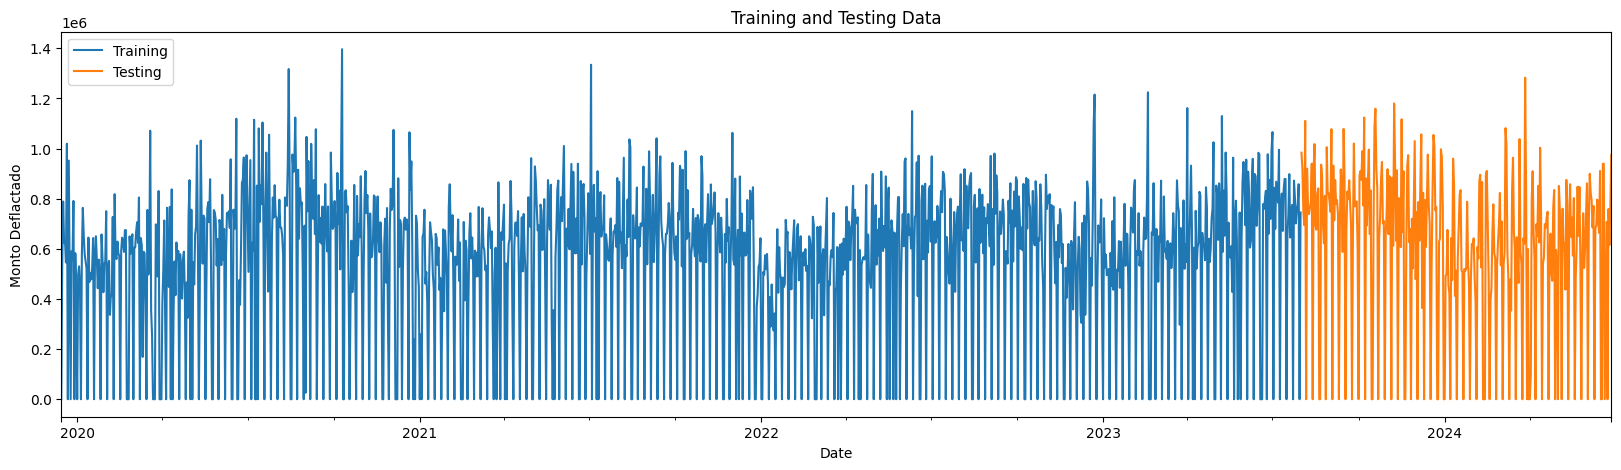

In [ ]:
import matplotlib.pyplot as plt

# Crear el gráfico
figure, ax = plt.subplots(figsize=(20, 5))

# Graficar los datos de entrenamiento y prueba
training_data['Monto_deflactado'].plot(ax=ax, label="Training")
testing_data['Monto_deflactado'].plot(ax=ax, label="Testing")

# Configurar etiquetas y título
ax.set_xlabel("Date")
ax.set_ylabel("Monto Deflactado")
ax.set_title("Training and Testing Data")

# Mostrar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


### LIghtGBM

In [ ]:
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform

# Preparar los datos
X = df_vitalcer.drop(columns=['Monto_deflactado'])
y = df_vitalcer['Monto_deflactado']

# Configuración del ExpandingWindowSplitter
initial_window = int(len(X) * 0.7)
step_length = 1
fh = [1]  # Horizonte de pronóstico

splitter = ExpandingWindowSplitter(
    initial_window=initial_window,
    step_length=step_length,
    fh=fh
)

# Definir los parámetros para Randomized Search
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 50, 100]
}

# Inicializar las listas para almacenar resultados
results = []

# Crear muestras de parámetros aleatorios
param_samples = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Realizar la validación cruzada manualmente
n_splits = splitter.get_n_splits(X)
split_number = 1

for train_index, test_index in splitter.split(X):
    print(f"Running split {split_number}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_mae = np.inf
    best_model = None

    for params in param_samples:
        model = lgb.LGBMRegressor(**params)

        model.fit(X_train, y_train)  # Sin early_stopping_rounds

        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)

        if mae < best_mae:
            best_mae = mae
            best_model = model

    # Realizar predicciones con el mejor modelo encontrado
    y_pred = best_model.predict(X_test)

    # Calcular métricas de evaluación
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results.append({
        'MAE': mae,
        'MSE': mse
    })

    split_number += 1

# Promediar los resultados de la validación cruzada
mean_mae = np.mean([result['MAE'] for result in results])
mean_mse = np.mean([result['MSE'] for result in results])

print(f"Mean Absolute Error (CV): {mean_mae}")
print(f"Mean Squared Error (CV): {mean_mse}")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
if best_model:
    # Obtener los hiperparámetros del mejor modelo
    best_params = best_model.get_params()
    print("Best Model Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

Best Model Hyperparameters:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.12732148682926614
max_depth: 10
min_child_samples: 50
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 100
n_jobs: None
num_leaves: 31
objective: None
random_state: None
reg_alpha: 0.0
reg_lambda: 0.0
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

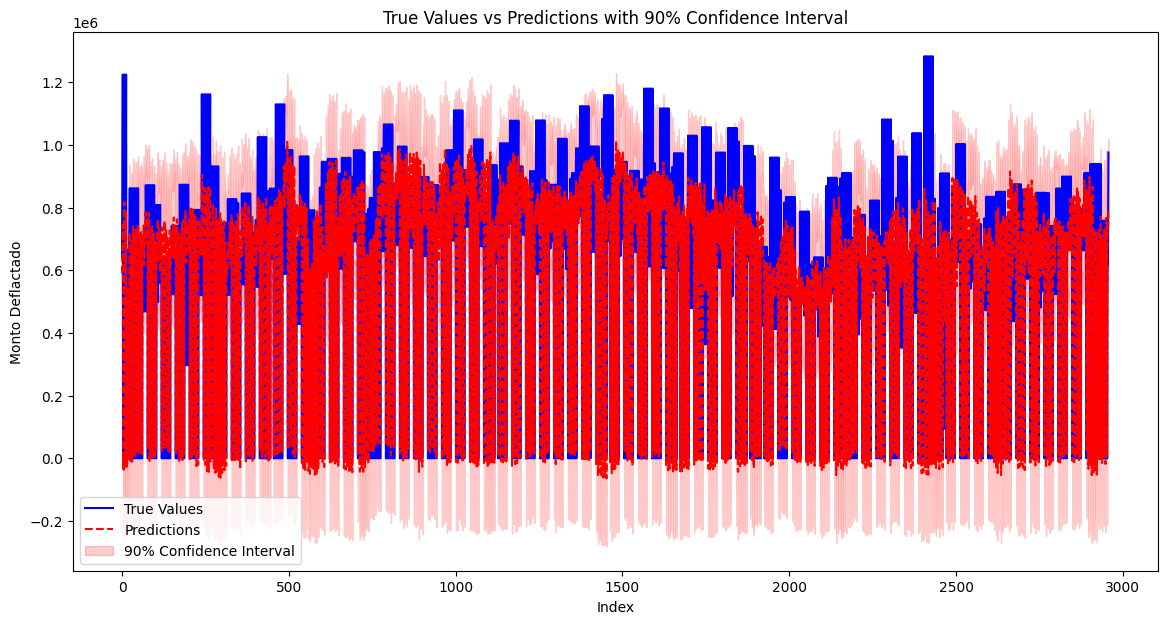

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform

# Preparar los datos
X = df_vitalcer.drop(columns=['Monto_deflactado'])
y = df_vitalcer['Monto_deflactado']

# Configuración del ExpandingWindowSplitter
initial_window = int(len(X) * 0.7)
step_length = 1
fh = [1,2,3,4,5,6]  # Horizonte de pronóstico

splitter = ExpandingWindowSplitter(
    initial_window=initial_window,
    step_length=step_length,
    fh=fh
)

# Definir los parámetros del modelo
params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.12732148682926614,
    'max_depth': 10,
    'min_child_samples': 50,
    'num_leaves': 31,
    'n_estimators': 100,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

# Inicializar las listas para almacenar resultados
results = []
all_y_true = []
all_y_pred = []

# Realizar la validación cruzada manualmente
n_splits = splitter.get_n_splits(X)
split_number = 1

for train_index, test_index in splitter.split(X):
    print(f"Running split {split_number}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)  # Sin early_stopping_rounds

    y_pred = model.predict(X_test)

    # Almacenar los resultados de esta partición
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calcular métricas de evaluación
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    split_number += 1

# Promediar los resultados de la validación cruzada
mean_mae = np.mean([result['MAE'] for result in results])
mean_mse = np.mean([result['MSE'] for result in results])
mean_rmse = np.mean([result['RMSE'] for result in results])

print(f"Mean Absolute Error (CV): {mean_mae}")
print(f"Mean Squared Error (CV): {mean_mse}")
print(f"Mean Root Mean Squared Error (CV): {mean_rmse}")

# Graficar las predicciones vs valores reales con intervalo de confianza del 90%
plt.figure(figsize=(14, 7))
plt.plot(all_y_true, label="True Values", color='blue')
plt.plot(all_y_pred, label="Predictions", color='red', linestyle='--')

# Calcular el intervalo de confianza del 90%
residuals = np.array(all_y_true) - np.array(all_y_pred)
std_dev = np.std(residuals)
conf_interval = 1.645 * std_dev  # 90% CI = 1.645 * std_dev

plt.fill_between(range(len(all_y_true)),
                 np.array(all_y_pred) - conf_interval,
                 np.array(all_y_pred) + conf_interval,
                 color='red', alpha=0.2, label='90% Confidence Interval')

plt.xlabel("Index")
plt.ylabel("Monto Deflactado")
plt.title("True Values vs Predictions with 90% Confidence Interval")
plt.legend()
plt.show()


### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Definir el modelo Gradient Boosting
gb_model = GradientBoostingRegressor()

# Definir los parámetros para Grid Search
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Configurar Grid Search
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                              scoring='neg_mean_squared_error', cv=5, verbose=0)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_gb.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_gb_model = grid_search_gb.best_estimator_

# Hacer predicciones con el conjunto de prueba
y_pred_test_gb = best_gb_model.predict(X_test)

# Evaluar el modelo con MAE y MSE
mae_test_gb = mean_absolute_error(y_test, y_pred_test_gb)
mse_test_gb = mean_squared_error(y_test, y_pred_test_gb)

print(f"Gradient Boosting Test MAE: {mae_test_gb}")
print(f"Gradient Boosting Test MSE: {mse_test_gb}")

# Guardar el mejor modelo
joblib.dump(best_gb_model, 'mejor_modelo_gradient_boosting.pkl')


Gradient Boosting Test MAE: 173162.58790118239
Gradient Boosting Test MSE: 46242126675.78997


['mejor_modelo_gradient_boosting.pkl']

In [ ]:
# Listar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search_gb.best_params_)


Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


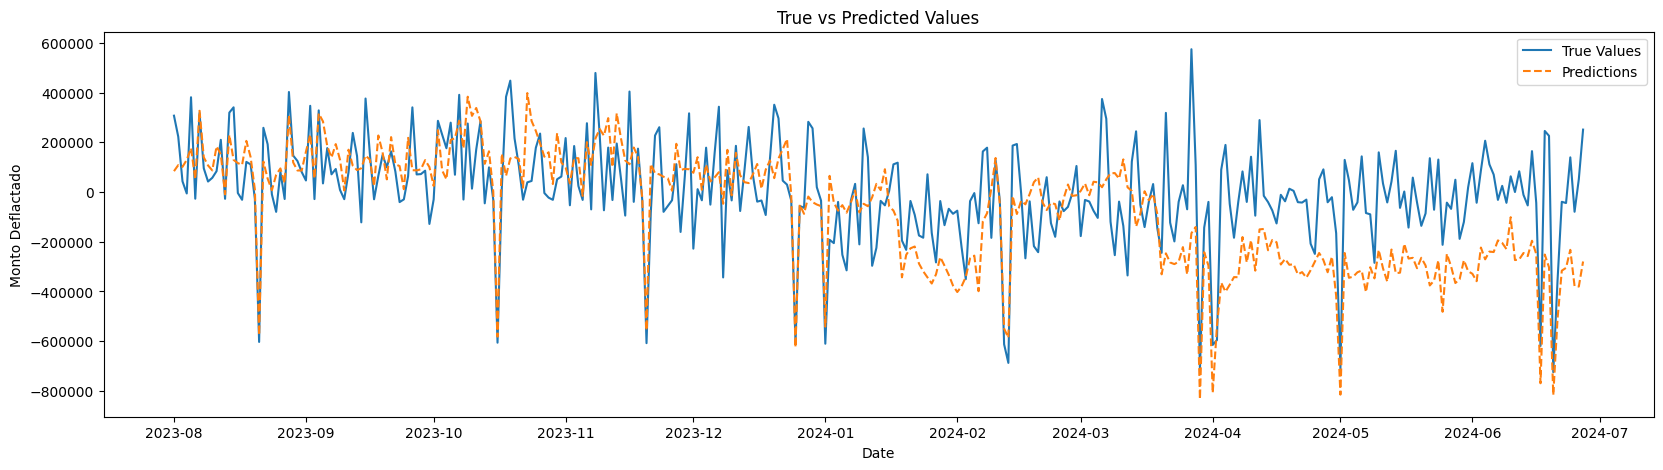

Evaluation MAE: 173162.58790118239
Evaluation MSE: 46242126675.78997


In [ ]:
# Evaluar los resultados de GridSearch
# Usa el mejor modelo encontrado por GridSearchCV para hacer predicciones
prediction = grid_search_gb.best_estimator_.predict(X_test)

# Asegúrate de que `plot_predictions` y `evaluate_model` estén definidas
# Si `testing_dates` es el índice del DataFrame `testing_data`, úsalo como x en el gráfico
testing_dates = testing_data.index

# Función para graficar las predicciones
def plot_predictions(dates, true_values, predictions):
    plt.figure(figsize=(20, 5))
    plt.plot(dates, true_values, label="True Values")
    plt.plot(dates, predictions, label="Predictions", linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Monto Deflactado")
    plt.title("True vs Predicted Values")
    plt.legend()
    plt.show()

# Función para evaluar el modelo
def evaluate_model(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    print(f"Evaluation MAE: {mae}")
    print(f"Evaluation MSE: {mse}")

# Graficar las predicciones y evaluar el modelo
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)


Running split 1/493
Running split 2/493
Running split 3/493
Running split 4/493
Running split 5/493
Running split 6/493
Running split 7/493
Running split 8/493
Running split 9/493
Running split 10/493
Running split 11/493
Running split 12/493
Running split 13/493
Running split 14/493
Running split 15/493
Running split 16/493
Running split 17/493
Running split 18/493
Running split 19/493
Running split 20/493
Running split 21/493
Running split 22/493
Running split 23/493
Running split 24/493
Running split 25/493
Running split 26/493
Running split 27/493
Running split 28/493
Running split 29/493
Running split 30/493
Running split 31/493
Running split 32/493
Running split 33/493
Running split 34/493
Running split 35/493
Running split 36/493
Running split 37/493
Running split 38/493
Running split 39/493
Running split 40/493
Running split 41/493
Running split 42/493
Running split 43/493
Running split 44/493
Running split 45/493
Running split 46/493
Running split 47/493
Running split 48/493
R

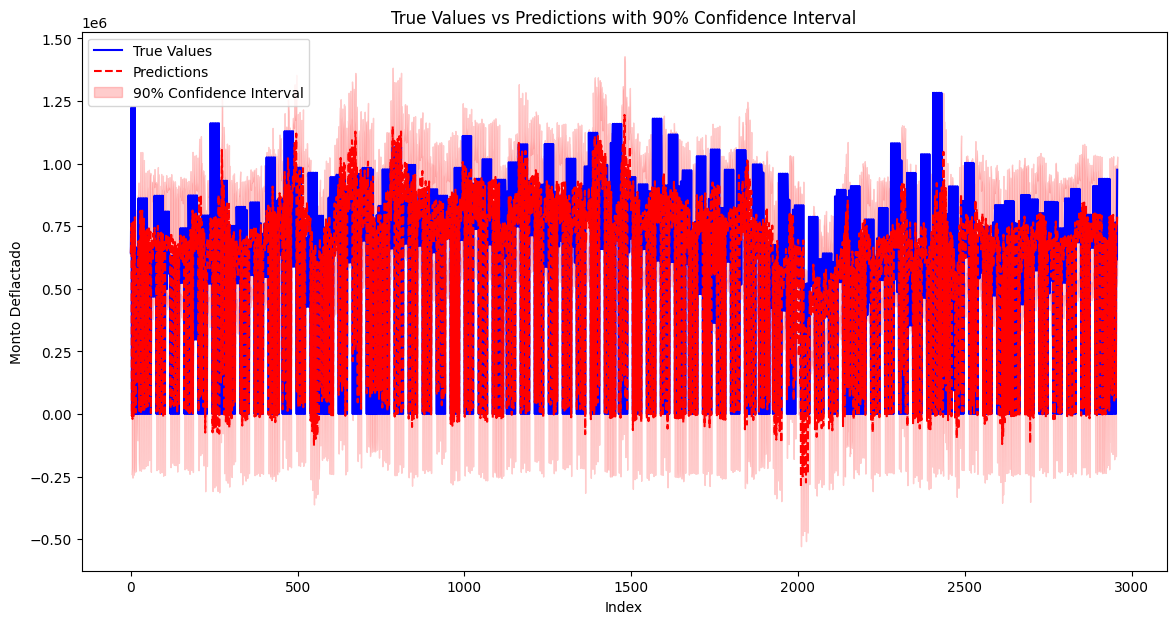

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Preparar los datos
X = df_vitalcer.drop(columns=['Monto_deflactado'])
y = df_vitalcer['Monto_deflactado']

# Configuración del ExpandingWindowSplitter
initial_window = int(len(X) * 0.7)
step_length = 1
fh = [ 1, 2, 3, 4, 5,6]  # Horizonte de pronóstico

splitter = ExpandingWindowSplitter(
    initial_window=initial_window,
    step_length=step_length,
    fh=fh
)

# Definir los parámetros del modelo
params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}

# Inicializar las listas para almacenar resultados
results = []
all_y_true = []
all_y_pred = []

# Realizar la validación cruzada manualmente
n_splits = splitter.get_n_splits(X)
split_number = 1

for train_index, test_index in splitter.split(X):
    print(f"Running split {split_number}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Almacenar los resultados de esta partición
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calcular métricas de evaluación
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    split_number += 1

# Promediar los resultados de la validación cruzada
mean_mae = np.mean([result['MAE'] for result in results])
mean_mse = np.mean([result['MSE'] for result in results])
mean_rmse = np.mean([result['RMSE'] for result in results])

print(f"Mean Absolute Error (CV): {mean_mae}")
print(f"Mean Squared Error (CV): {mean_mse}")
print(f"Mean Root Mean Squared Error (CV): {mean_rmse}")

# Graficar las predicciones vs valores reales con intervalo de confianza del 90%
plt.figure(figsize=(14, 7))
plt.plot(all_y_true, label="True Values", color='blue')
plt.plot(all_y_pred, label="Predictions", color='red', linestyle='--')

# Calcular el intervalo de confianza del 90%
residuals = np.array(all_y_true) - np.array(all_y_pred)
std_dev = np.std(residuals)
conf_interval = 1.645 * std_dev  # 90% CI = 1.645 * std_dev

plt.fill_between(range(len(all_y_true)),
                 np.array(all_y_pred) - conf_interval,
                 np.array(all_y_pred) + conf_interval,
                 color='red', alpha=0.2, label='90% Confidence Interval')

plt.xlabel("Index")
plt.ylabel("Monto Deflactado")
plt.title("True Values vs Predictions with 90% Confidence Interval")
plt.legend()
plt.show()


### AdaBoost

AdaBoost Training MAE: 98520.59
AdaBoost Training MSE: 16289603920.31
AdaBoost Test MAE: 114653.04
AdaBoost Test MSE: 20060656183.52


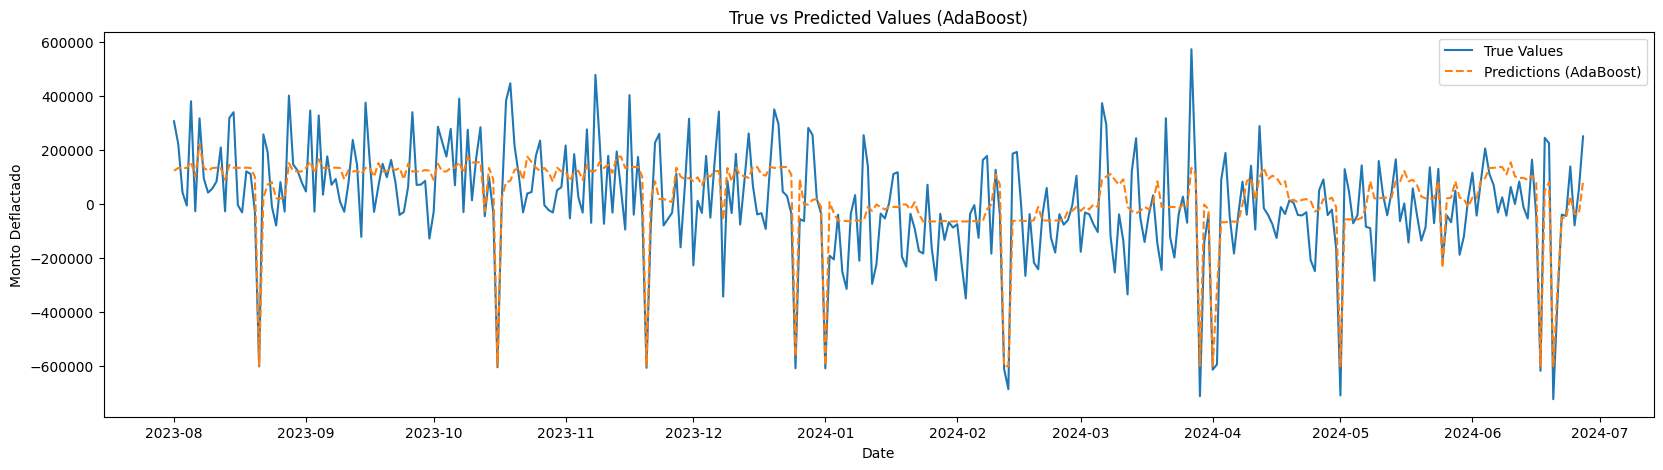

AdaBoost Evaluation MAE: 114653.04
AdaBoost Evaluation MSE: 20060656183.52


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib

# Definir el modelo AdaBoost
ab_model = AdaBoostRegressor()

# Definir los parámetros para Grid Search
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Configurar Grid Search
grid_search_ab = GridSearchCV(estimator=ab_model, param_grid=param_grid_ab,
                              scoring='neg_mean_squared_error', cv=5, verbose=0)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_ab.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_ab_model = grid_search_ab.best_estimator_

# Hacer predicciones con el conjunto de prueba
y_pred_test_ab = best_ab_model.predict(X_test)

# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train_ab = best_ab_model.predict(X_train)
mae_train_ab = mean_absolute_error(y_train, y_pred_train_ab)
mse_train_ab = mean_squared_error(y_train, y_pred_train_ab)

# Evaluar el modelo en el conjunto de prueba
mae_test_ab = mean_absolute_error(y_test, y_pred_test_ab)
mse_test_ab = mean_squared_error(y_test, y_pred_test_ab)

print(f"AdaBoost Training MAE: {mae_train_ab:.2f}")
print(f"AdaBoost Training MSE: {mse_train_ab:.2f}")
print(f"AdaBoost Test MAE: {mae_test_ab:.2f}")
print(f"AdaBoost Test MSE: {mse_test_ab:.2f}")

# Guardar el mejor modelo
joblib.dump(best_ab_model, 'mejor_modelo_adaboost.pkl')

# Función para graficar las predicciones
def plot_predictions(dates, true_values, predictions, model_name):
    plt.figure(figsize=(20, 5))
    plt.plot(dates, true_values, label="True Values")
    plt.plot(dates, predictions, label=f"Predictions ({model_name})", linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Monto Deflactado")
    plt.title(f"True vs Predicted Values ({model_name})")
    plt.legend()
    plt.show()

# Función para evaluar el modelo
def evaluate_model(true_values, predictions, model_name):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    print(f"{model_name} Evaluation MAE: {mae:.2f}")
    print(f"{model_name} Evaluation MSE: {mse:.2f}")

# Graficar las predicciones y evaluar el modelo para AdaBoost
plot_predictions(testing_dates, y_test, y_pred_test_ab, "AdaBoost")
evaluate_model(y_test, y_pred_test_ab, "AdaBoost")


In [ ]:
# Listar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search_ab.best_params_)

Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'n_estimators': 50}


Running split 1/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 2/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 3/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 4/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 5/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 6/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 7/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 8/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 9/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 10/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 11/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 12/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 13/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 14/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 15/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 16/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 17/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 18/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 19/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 20/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 21/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 22/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 23/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 24/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 25/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 26/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 27/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 28/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 29/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 30/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 31/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 32/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 33/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 34/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 35/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 36/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 37/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 38/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 39/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 40/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 41/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 42/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 43/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 44/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 45/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 46/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 47/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 48/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 49/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 50/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 51/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 52/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 53/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 54/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 55/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 56/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 57/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 58/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 59/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 60/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 61/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 62/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 63/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 64/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 65/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 66/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 67/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 68/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 69/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 70/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 71/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 72/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 73/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 74/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 75/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 76/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 77/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 78/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 79/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 80/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 81/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 82/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 83/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 84/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 85/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 86/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 87/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 88/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 89/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 90/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 91/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 92/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 93/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 94/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 95/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 96/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 97/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 98/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 99/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 100/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 101/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 102/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 103/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 104/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 105/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 106/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 107/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 108/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 109/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 110/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 111/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 112/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 113/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 114/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 115/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 116/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 117/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 118/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 119/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 120/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 121/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 122/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 123/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 124/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 125/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 126/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 127/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 128/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 129/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 130/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 131/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 132/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 133/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 134/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 135/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 136/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 137/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 138/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 139/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 140/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 141/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 142/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 143/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 144/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 145/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 146/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 147/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 148/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 149/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 150/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 151/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 152/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 153/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 154/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 155/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 156/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 157/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 158/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 159/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 160/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 161/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 162/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 163/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 164/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 165/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 166/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 167/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 168/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 169/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 170/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 171/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 172/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 173/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 174/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 175/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 176/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 177/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 178/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 179/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 180/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 181/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 182/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 183/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 184/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 185/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 186/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 187/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 188/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 189/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 190/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 191/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 192/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 193/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 194/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 195/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 196/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 197/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 198/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 199/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 200/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 201/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 202/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 203/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 204/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 205/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 206/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 207/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 208/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 209/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 210/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 211/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 212/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 213/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 214/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 215/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 216/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 217/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 218/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 219/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 220/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 221/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 222/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 223/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 224/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 225/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 226/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 227/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 228/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 229/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 230/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 231/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 232/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 233/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 234/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 235/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 236/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 237/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 238/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 239/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 240/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 241/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 242/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 243/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 244/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 245/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 246/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 247/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 248/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 249/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 250/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 251/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 252/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 253/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 254/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 255/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 256/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 257/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 258/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 259/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 260/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 261/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 262/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 263/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 264/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 265/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 266/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 267/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 268/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 269/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 270/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 271/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 272/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 273/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 274/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 275/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 276/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 277/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 278/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 279/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 280/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 281/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 282/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 283/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 284/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 285/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 286/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 287/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 288/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 289/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 290/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 291/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 292/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 293/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 294/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 295/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 296/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 297/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 298/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 299/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 300/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 301/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 302/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 303/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 304/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 305/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 306/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 307/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 308/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 309/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 310/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 311/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 312/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 313/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 314/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 315/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 316/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 317/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 318/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 319/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 320/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 321/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 322/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 323/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 324/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 325/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 326/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 327/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 328/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 329/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 330/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 331/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 332/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 333/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 334/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 335/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 336/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 337/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 338/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 339/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 340/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 341/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 342/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 343/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 344/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 345/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 346/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 347/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 348/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 349/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 350/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 351/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 352/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 353/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 354/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 355/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 356/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 357/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 358/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 359/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 360/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 361/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 362/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 363/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 364/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 365/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 366/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 367/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 368/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 369/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 370/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 371/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 372/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 373/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 374/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 375/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 376/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 377/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 378/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 379/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 380/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 381/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 382/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 383/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 384/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 385/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 386/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 387/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 388/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 389/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 390/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 391/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 392/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 393/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 394/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 395/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 396/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 397/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 398/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 399/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 400/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 401/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 402/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 403/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 404/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 405/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 406/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 407/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 408/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 409/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 410/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 411/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 412/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 413/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 414/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 415/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 416/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 417/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 418/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 419/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 420/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 421/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 422/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 423/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 424/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 425/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 426/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 427/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 428/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 429/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 430/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 431/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 432/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 433/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 434/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 435/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 436/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 437/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 438/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 439/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 440/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 441/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 442/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 443/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 444/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 445/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 446/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 447/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 448/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 449/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 450/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 451/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 452/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 453/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 454/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 455/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 456/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 457/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 458/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 459/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 460/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 461/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 462/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 463/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 464/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 465/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 466/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 467/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 468/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 469/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 470/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 471/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 472/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 473/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 474/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 475/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 476/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 477/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 478/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 479/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 480/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 481/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 482/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 483/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 484/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 485/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 486/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 487/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 488/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 489/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 490/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 491/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 492/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Running split 493/493


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Mean Absolute Error (CV): 99017.37628042769
Mean Squared Error (CV): 18653431775.563595
Mean Root Mean Squared Error (CV): 129015.8600033431


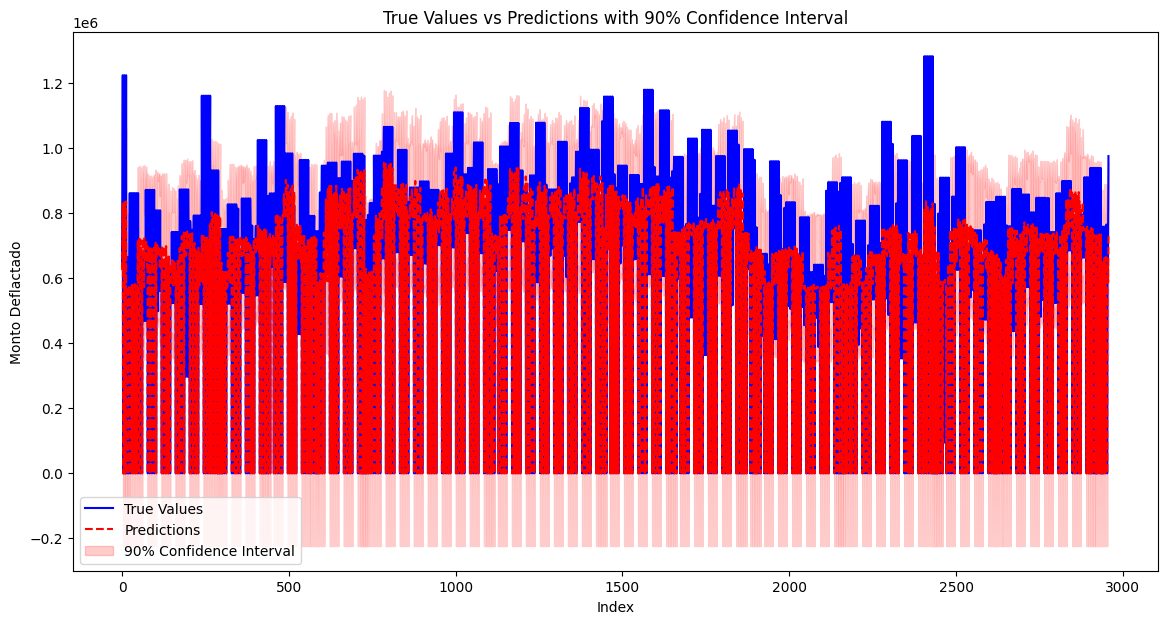

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor  # AdaBoostRegressor requiere un estimador base

# Preparar los datos
X = df_vitalcer.drop(columns=['Monto_deflactado'])
y = df_vitalcer['Monto_deflactado']

# Configuración del ExpandingWindowSplitter
initial_window = int(len(X) * 0.7)
step_length = 1
fh = [ 1, 2, 3, 4, 5,6]  # Horizonte de pronóstico

splitter = ExpandingWindowSplitter(
    initial_window=initial_window,
    step_length=step_length,
    fh=fh
)

# Definir los parámetros del modelo
params = {
    'learning_rate': 0.1,
    'n_estimators': 50,
    'base_estimator': DecisionTreeRegressor(max_depth=3)  # Estimador base
}

# Inicializar las listas para almacenar resultados
results = []
all_y_true = []
all_y_pred = []

# Realizar la validación cruzada manualmente
n_splits = splitter.get_n_splits(X)
split_number = 1

for train_index, test_index in splitter.split(X):
    print(f"Running split {split_number}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = AdaBoostRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Almacenar los resultados de esta partición
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calcular métricas de evaluación
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    split_number += 1

# Promediar los resultados de la validación cruzada
mean_mae = np.mean([result['MAE'] for result in results])
mean_mse = np.mean([result['MSE'] for result in results])
mean_rmse = np.mean([result['RMSE'] for result in results])

print(f"Mean Absolute Error (CV): {mean_mae}")
print(f"Mean Squared Error (CV): {mean_mse}")
print(f"Mean Root Mean Squared Error (CV): {mean_rmse}")

# Graficar las predicciones vs valores reales con intervalo de confianza del 90%
plt.figure(figsize=(14, 7))
plt.plot(all_y_true, label="True Values", color='blue')
plt.plot(all_y_pred, label="Predictions", color='red', linestyle='--')

# Calcular el intervalo de confianza del 90%
residuals = np.array(all_y_true) - np.array(all_y_pred)
std_dev = np.std(residuals)
conf_interval = 1.645 * std_dev  # 90% CI = 1.645 * std_dev

plt.fill_between(range(len(all_y_true)),
                 np.array(all_y_pred) - conf_interval,
                 np.array(all_y_pred) + conf_interval,
                 color='red', alpha=0.2, label='90% Confidence Interval')

plt.xlabel("Index")
plt.ylabel("Monto Deflactado")
plt.title("True Values vs Predictions with 90% Confidence Interval")
plt.legend()
plt.show()


### XGBoost

In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Definir el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Definir los parámetros para Grid Search
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Configurar Grid Search
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                                scoring='neg_mean_squared_error', cv=5, verbose=0)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_xgb.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_xgb_model = grid_search_xgb.best_estimator_

# Hacer predicciones con el conjunto de prueba
y_pred_test_xgb = best_xgb_model.predict(X_test)

# Evaluar el modelo con MAE y MSE
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)

print(f"XGBoost Test MAE: {mae_test_xgb}")
print(f"XGBoost Test MSE: {mse_test_xgb}")

# Guardar el mejor modelo
joblib.dump(best_xgb_model, 'mejor_modelo_xgboost.pkl')



XGBoost Test MAE: 109777.39304613454
XGBoost Test MSE: 19661737169.12676


['mejor_modelo_xgboost.pkl']

In [ ]:
# Listar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search_xgb.best_params_)

Mejores hiperparámetros encontrados:
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}


### Extra Tree

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Definir el modelo Extra Trees
et_model = ExtraTreesRegressor()

# Definir los parámetros para Grid Search
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'bootstrap': [False, True]
}

# Configurar Grid Search
grid_search_et = GridSearchCV(estimator=et_model, param_grid=param_grid_et,
                              scoring='neg_mean_squared_error', cv=5, verbose=0)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_et.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_et_model = grid_search_et.best_estimator_

# Hacer predicciones con el conjunto de prueba
y_pred_test_et = best_et_model.predict(X_test)

# Evaluar el modelo con MAE y MSE
mae_test_et = mean_absolute_error(y_test, y_pred_test_et)
mse_test_et = mean_squared_error(y_test, y_pred_test_et)

print(f"Extra Trees Test MAE: {mae_test_et}")
print(f"Extra Trees Test MSE: {mse_test_et}")

# Guardar el mejor modelo
joblib.dump(best_et_model, 'mejor_modelo_extra_trees.pkl')


Extra Trees Test MAE: 108233.28350307595
Extra Trees Test MSE: 19366120953.94182


['mejor_modelo_extra_trees.pkl']

In [ ]:
# Listar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search_et.best_params_)

Mejores hiperparámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


Running split 1/493
Running split 2/493
Running split 3/493
Running split 4/493
Running split 5/493
Running split 6/493
Running split 7/493
Running split 8/493
Running split 9/493
Running split 10/493
Running split 11/493
Running split 12/493
Running split 13/493
Running split 14/493
Running split 15/493
Running split 16/493
Running split 17/493
Running split 18/493
Running split 19/493
Running split 20/493
Running split 21/493
Running split 22/493
Running split 23/493
Running split 24/493
Running split 25/493
Running split 26/493
Running split 27/493
Running split 28/493
Running split 29/493
Running split 30/493
Running split 31/493
Running split 32/493
Running split 33/493
Running split 34/493
Running split 35/493
Running split 36/493
Running split 37/493
Running split 38/493
Running split 39/493
Running split 40/493
Running split 41/493
Running split 42/493
Running split 43/493
Running split 44/493
Running split 45/493
Running split 46/493
Running split 47/493
Running split 48/493
R

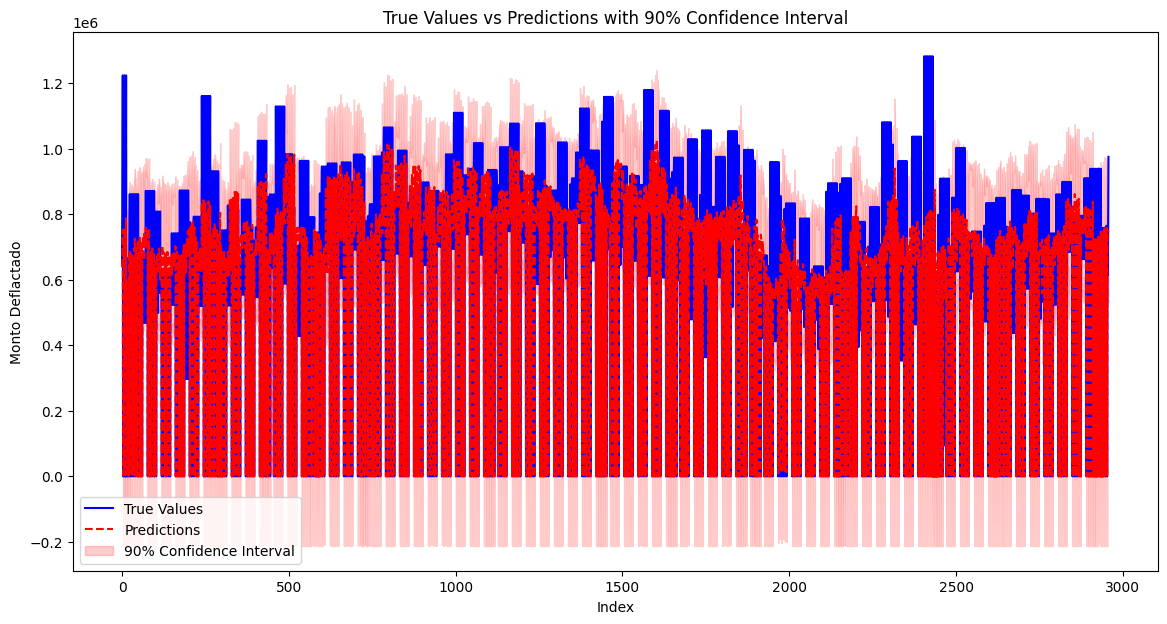

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor

# Preparar los datos
X = df_vitalcer.drop(columns=['Monto_deflactado'])
y = df_vitalcer['Monto_deflactado']

# Configuración del ExpandingWindowSplitter
initial_window = int(len(X) * 0.7)
step_length = 1
fh = [1, 2, 3, 4, 5, 6]  # Horizonte de pronóstico

splitter = ExpandingWindowSplitter(
    initial_window=initial_window,
    step_length=step_length,
    fh=fh
)

# Definir los parámetros del modelo Extra Trees
params = {
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 100
}

# Inicializar las listas para almacenar resultados
results = []
all_y_true = []
all_y_pred = []

# Realizar la validación cruzada manualmente
n_splits = splitter.get_n_splits(X)
split_number = 1

for train_index, test_index in splitter.split(X):
    print(f"Running split {split_number}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = ExtraTreesRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Almacenar los resultados de esta partición
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calcular métricas de evaluación
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    split_number += 1

# Promediar los resultados de la validación cruzada
mean_mae = np.mean([result['MAE'] for result in results])
mean_mse = np.mean([result['MSE'] for result in results])
mean_rmse = np.mean([result['RMSE'] for result in results])

print(f"Mean Absolute Error (CV): {mean_mae}")
print(f"Mean Squared Error (CV): {mean_mse}")
print(f"Mean Root Mean Squared Error (CV): {mean_rmse}")

# Graficar las predicciones vs valores reales con intervalo de confianza del 90%
plt.figure(figsize=(14, 7))
plt.plot(all_y_true, label="True Values", color='blue')
plt.plot(all_y_pred, label="Predictions", color='red', linestyle='--')

# Calcular el intervalo de confianza del 90%
residuals = np.array(all_y_true) - np.array(all_y_pred)
std_dev = np.std(residuals)
conf_interval = 1.645 * std_dev  # 90% CI = 1.645 * std_dev

plt.fill_between(range(len(all_y_true)),
                 np.array(all_y_pred) - conf_interval,
                 np.array(all_y_pred) + conf_interval,
                 color='red', alpha=0.2, label='90% Confidence Interval')

plt.xlabel("Index")
plt.ylabel("Monto Deflactado")
plt.title("True Values vs Predictions with 90% Confidence Interval")
plt.legend()
plt.show()
